# FinOpt: Complete Workflow Validation

# Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

# --- Standard libs ---
import numpy as np
import pandas as pd

# --- FinOpt modules ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel
from src.model import FinancialModel, SimulationResult
from src.optimization import CVaROptimizer
from src.goals import IntermediateGoal, TerminalGoal
from src.withdrawal import WithdrawalEvent, WithdrawalSchedule, WithdrawalModel, StochasticWithdrawal

# Configuration: Seasonality and Contribution

In [2]:
# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---

# Structure: months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

seasonality_variable = [0.00, 0.00, 0.00, 0.6, 1, 1.16,
                        1, 1.10, 0.50, 0.90, 0.85, 1]

monthly_contrib_fixed = [0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
                         0.45, 0.45, 0.45, 0.45, 0.45, 0.3]

monthly_contrib_variable = [1.0] * 12

monthly_contribution ={"fixed": monthly_contrib_fixed, "variable": monthly_contrib_variable}

# Initialize FinancialModel 

In [3]:
# IncomeModel Instantiation
income = IncomeModel(
    fixed=FixedIncome(
        base=1_488_000.0,       # CLP/month
        annual_growth=0.03,     # 3% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # +400k in April 2026
            date(2027, 6, 1): 400_000,   # +400k in Jun 2027
            date(2028, 6, 1): 300_000   # +300k in Jun 2028
        },
        name="fixed"
    ),
    variable=VariableIncome(
        base=60_000.0,         # Base variable income
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly noise
        floor=0.0,              # No negative income
        cap=400_000.0,          # Maximum 400k/month
        annual_growth=0.0,      # No growth in variable
        name="variable"
    ),
    monthly_contribution = monthly_contribution
)

# --- Account configuration ---
accounts = [
    Account.from_annual(
        name="Cuenta Ahorro Vivienda (BE)",
        annual_return=0.025,
        annual_volatility=0.01,
        initial_wealth=1600000
    ),
    Account.from_annual(
        name="Conservative Clooney (Fintual)",
        annual_return=0.08,
        annual_volatility=0.09,
        initial_wealth=744747
    ),
    Account.from_annual(
        name="Risky Norris (Fintual)",
        annual_return=0.14,
        annual_volatility=0.15,
        initial_wealth=900000
    )
]

# --- Correlation matrix (2x2) ---
# UF portfolio have moderate positive correlation (rho = 0.2)
correlation_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.5],
    [0.0, 0.5, 1.0]
])

# --- Initialize FinancialModel ---
model = FinancialModel(income, accounts, default_correlation = correlation_matrix)
model

FinancialModel(M=3, accounts=['Cuenta Ahorro Vivienda (BE)', 'Conservative Clooney (Fintual)', 'Risky Norris (Fintual)'], cache=enabled)

# Simulation parameters

In [4]:
# --- Simulation parameters ---
n_sims = 500
months = 26  
start_date = date(2025, 11, 1)

# Income Module

Total monthly income at time $t$ is composed of fixed and variable parts:

$$
Y_t = y_t^{\text{fixed}} + Y_t^{\text{variable}}
$$

## **Fixed Income**

The fixed component, $y_t^{\text{fixed}}$, reflects a baseline salary subject to compounded annual growth $g$ and scheduled raises ${d_k, \Delta_k}$ (e.g., promotions or tenure milestones):

$$y_t^{\text{fixed}} = \text{current\_salary}(t) \cdot (1+m)^{\Delta t}$$

where $m = (1 + g)^{1/12} - 1$ is the **monthly compounded rate**, and $\Delta t$ represents time since the last raise.

## **Variable Income**

The variable component, $Y_t^{\text{variable}}$, models irregular income sources (e.g., freelance work or bonuses) with:

* **Seasonality**: $s \in \mathbb{R}^{12}$ (multiplicative monthly factors),
* **Noise**: $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ (Gaussian shocks),
* **Growth**: same compounded rate $m$ applied to a base income level,
* **Boundaries**: optional floor and cap constraints.

The underlying stochastic projection is:

$$
\tilde{Y}_t = \max(\text{floor},\ \mu_t (1 + \epsilon_t)), \quad \text{where } \mu_t = \text{base} \cdot (1 + m)^t \cdot s_{(t \bmod 12)}
$$

Then, guardrails are applied as:

$$
Y_t^{\text{variable}} = \begin{cases}
0 & \text{if } \tilde{Y}_t < 0 \\
\tilde{Y}_t & \text{if } 0 \leq \tilde{Y}_t \leq \text{cap} \\
\text{cap} & \text{if } \tilde{Y}_t > \text{cap}
\end{cases}
$$

> **Note:** In expectation (ignoring noise truncation), $\mathbb{E}[Y_t] = y_t^{\text{fixed}} + \mu_t$

## Income Projection

Dual-axis plot with:
- **Left axis**: Fixed income (deterministic) + Total income
- **Right axis**: Variable income (stochastic with trajectories)
- **Trajectories**: Individual noise realizations (n=300)
- **Confidence band**: 95% CI for variable income

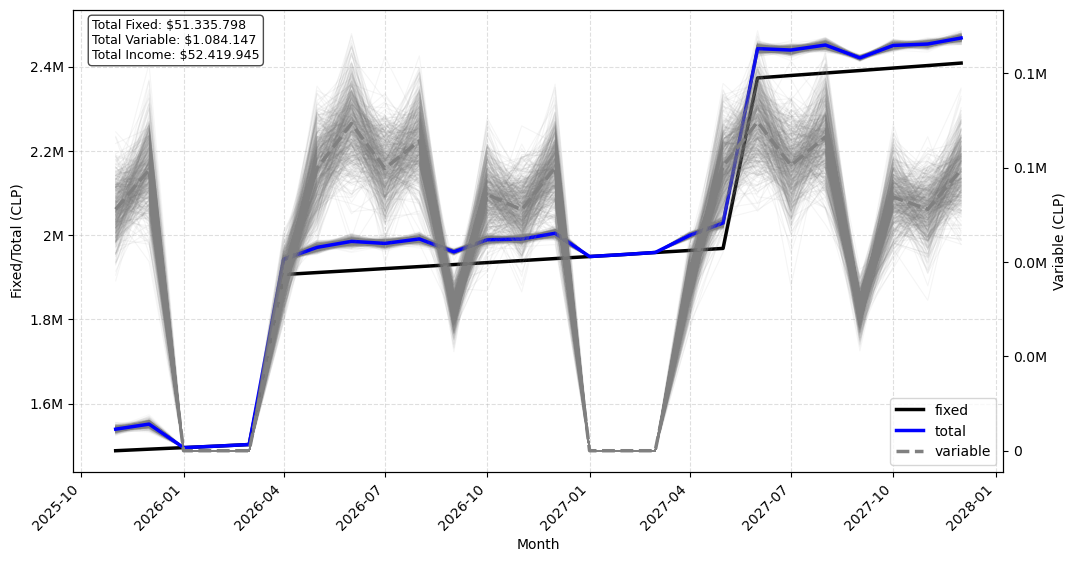

In [5]:
# Income Projection Simulation
model.plot(mode='income', T=months, start=start_date)

## Contribution Projection

A fraction of income is allocated each month through calendar-rotating schedules:
$$
A_t = \alpha_{(t \bmod 12)}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t \bmod 12)}^{v} \cdot Y_t^{\text{variable}}
$$

where $\alpha^f, \alpha^v \in [0,1]^{12}$ control the fixed and variable contribution rates by applying the 12-month fractional arrays to projected incomes, rotated according to `start` date and repeated cyclically for horizons > 12 months.

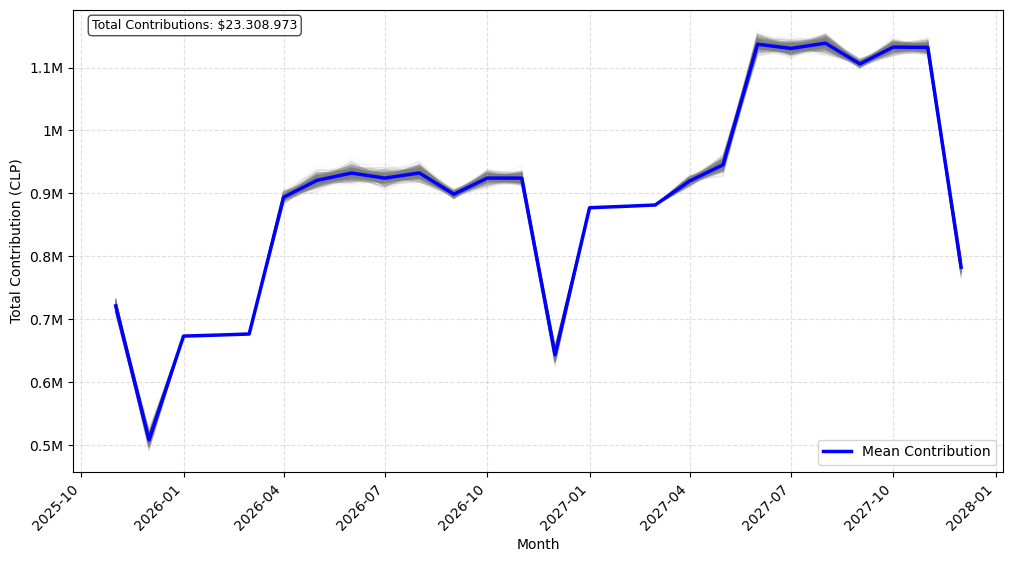

In [6]:
# Contribution Projection Simulation
model.plot(mode='contributions', T=months, start=start_date)

# Return Module

## Multi-Account Return Model

For $M$ accounts with correlated returns:

$$1 + R_t^m \sim \text{LogNormal}(\mu_{\log}^m, \Sigma)$$

where $\Sigma = D \cdot \rho \cdot D$ is the covariance matrix:
- $D = \text{diag}(\sigma_{\log}^1, \ldots, \sigma_{\log}^M)$
- $\rho \in \mathbb{R}^{M \times M}$ is the correlation matrix (symmetric, PSD)



## Monthly Return Distribution (Marginal Analysis)

Visualizes IID monthly returns across both accounts with 4 panels:
- **Trajectories**: Individual paths for each account
- **Histograms**: Marginal distributions (overlaid)
- **Statistics**: Mean, std, quantiles per account

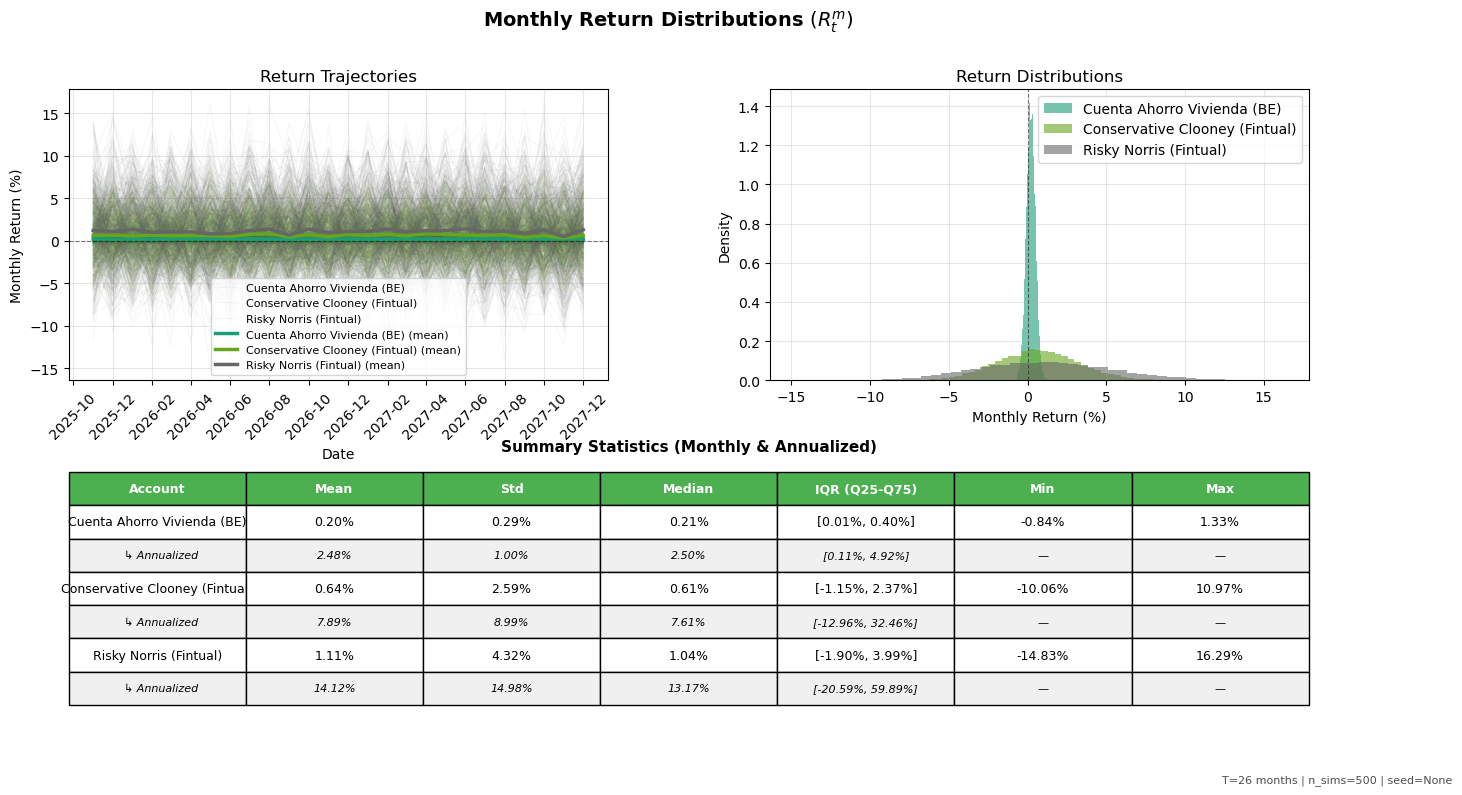

In [7]:
model.plot(mode = 'returns', T = months, start=start_date)

## Cumulative Returns per Account

For $M$ accounts with correlated returns:
$$R_{\text{cm}}^m(T) = \prod_{t=0}^{T-1}(1 + R_t^m) - 1$$
**Cross-sectional correlation** persists through time but does not compound.

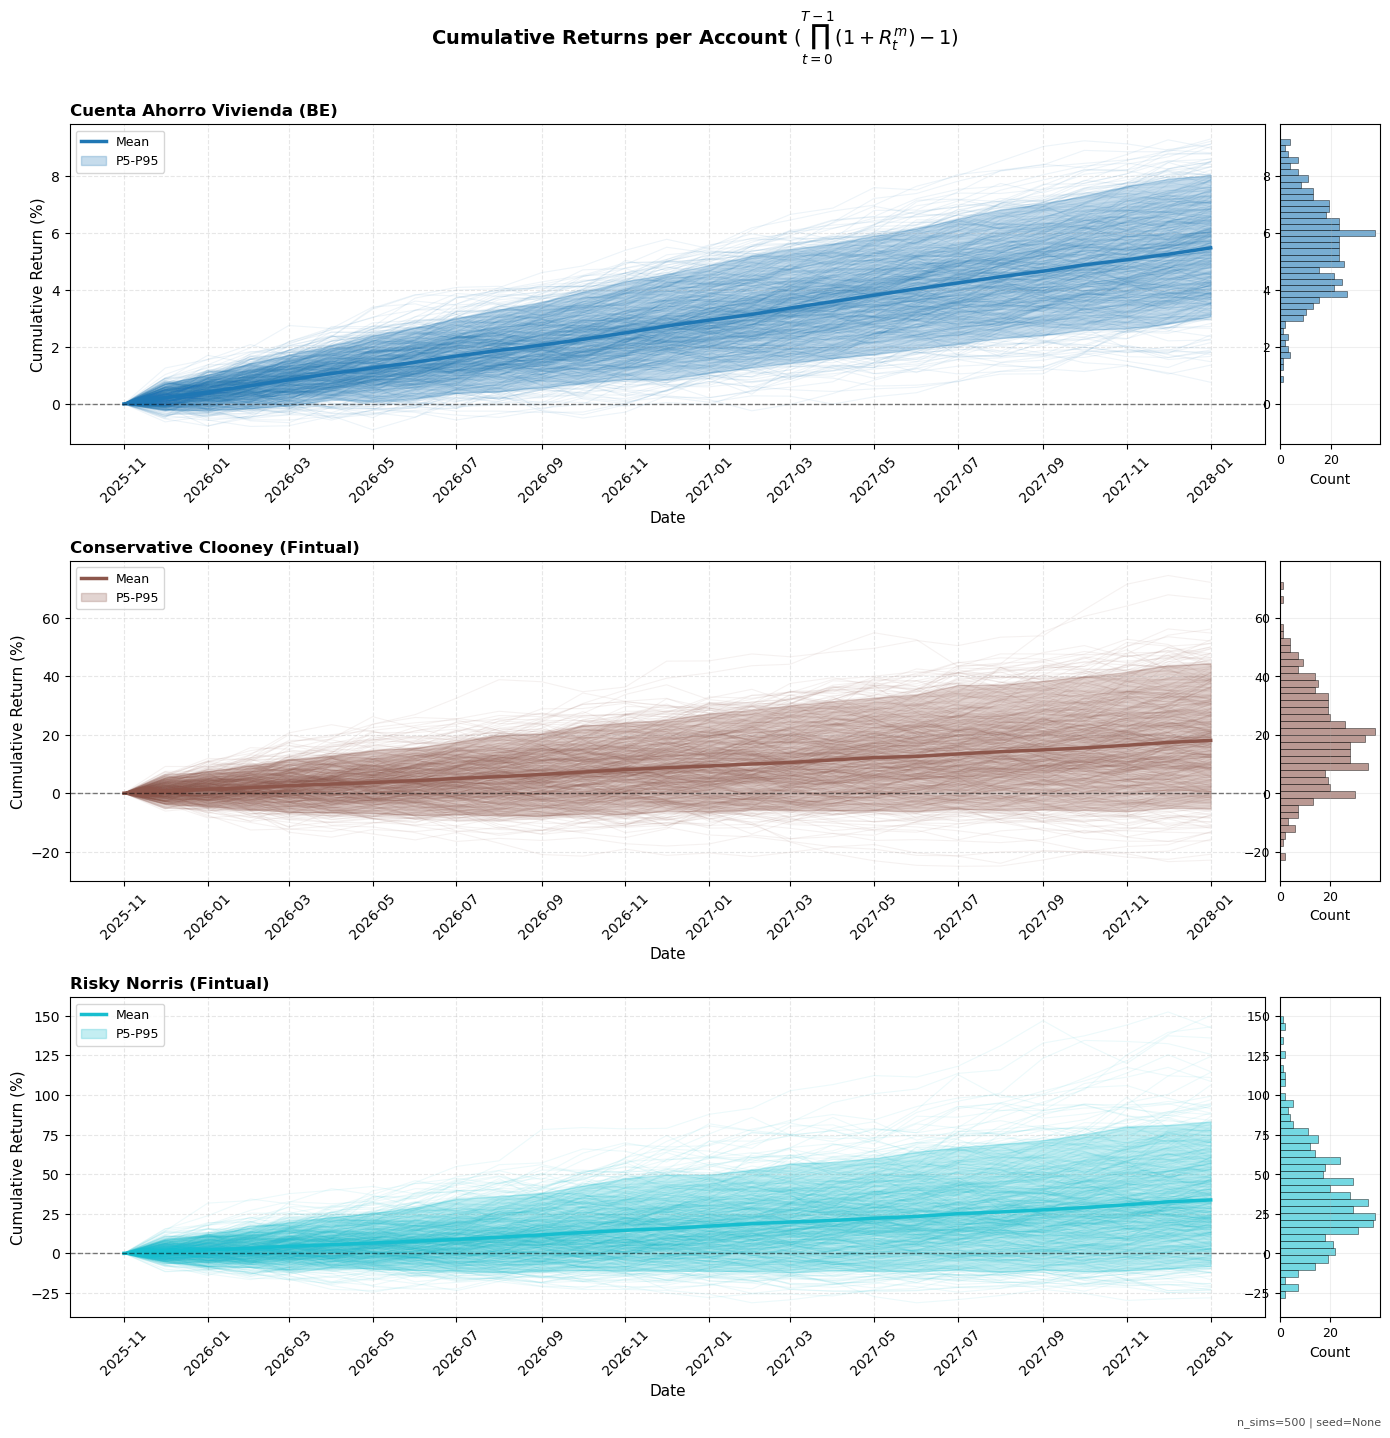

In [8]:
model.plot(mode = 'returns_cumulative', T = months, start=start_date)

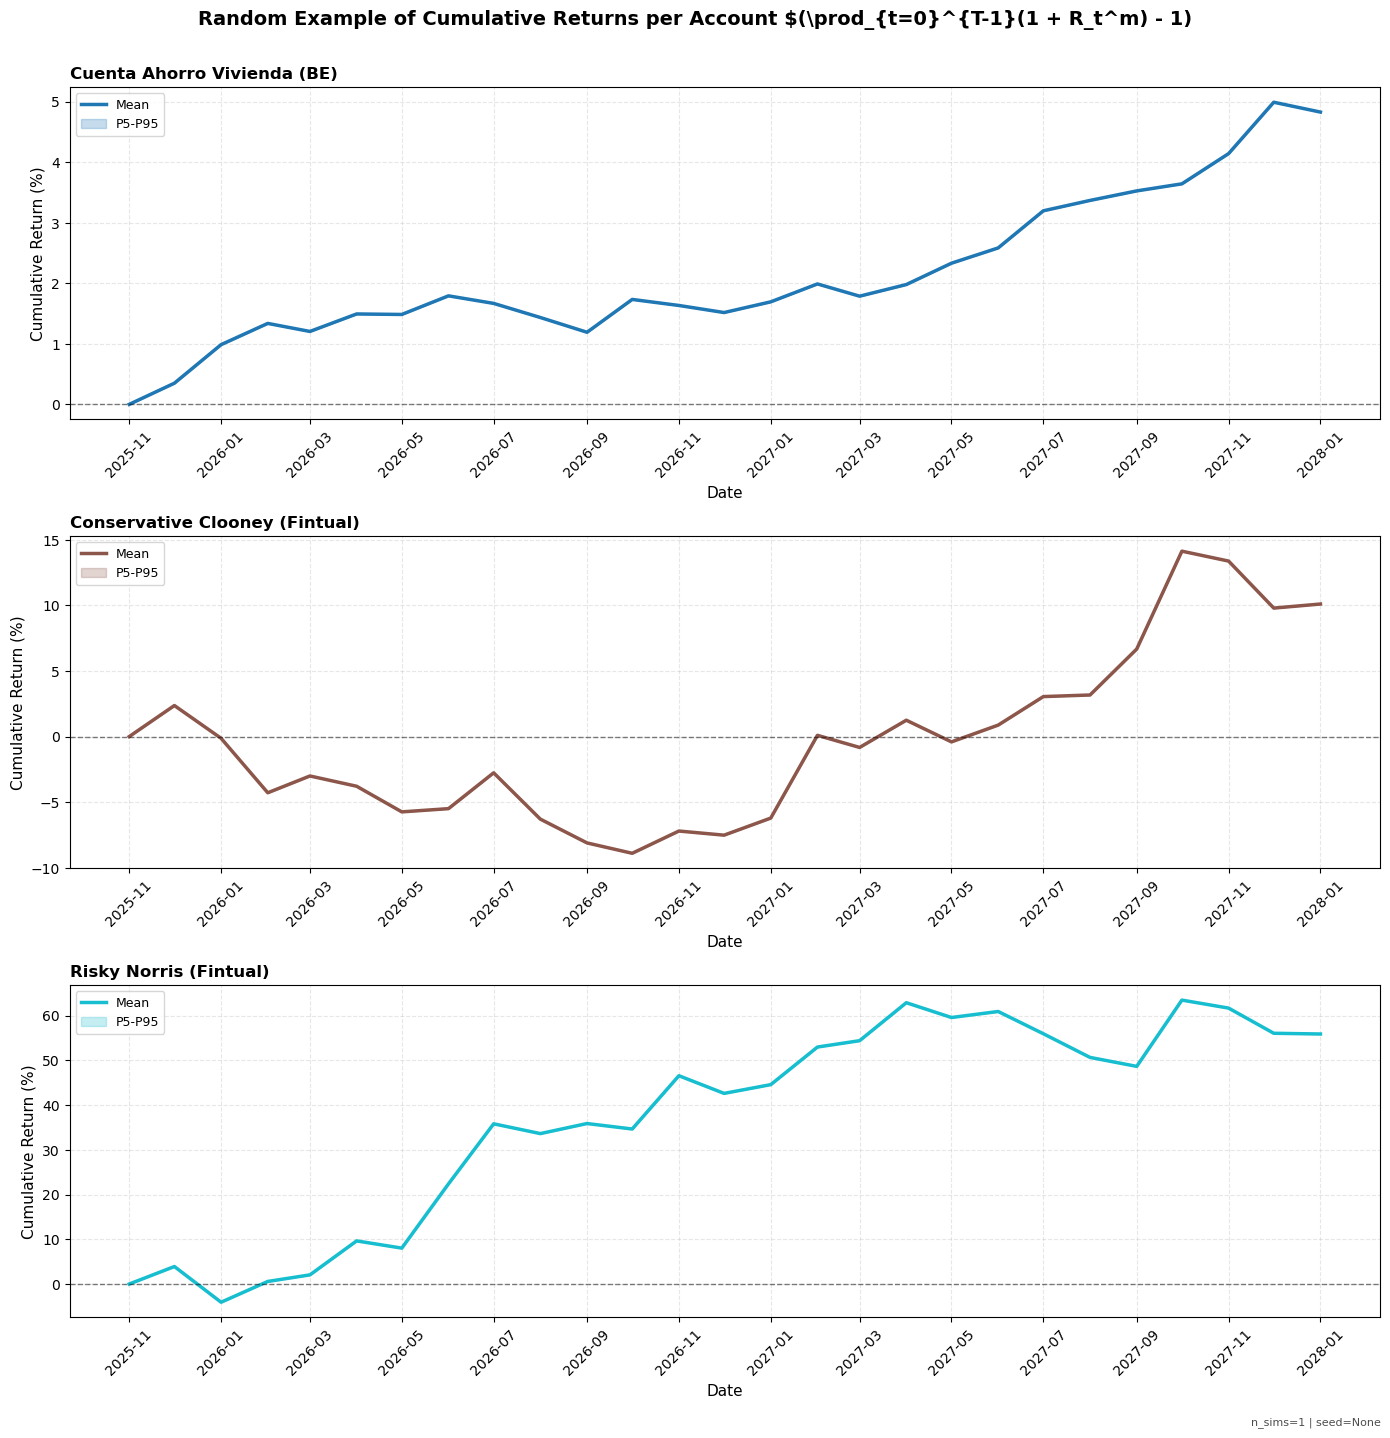

In [9]:
model.plot(mode = 'returns_cumulative', T = months, start=start_date, n_sims=1, title= r'Random Example of Cumulative Returns per Account $(\prod_{t=0}^{T-1}(1 + R_t^m) - 1)')

## Horizon Analysis: Time Diversification by Account

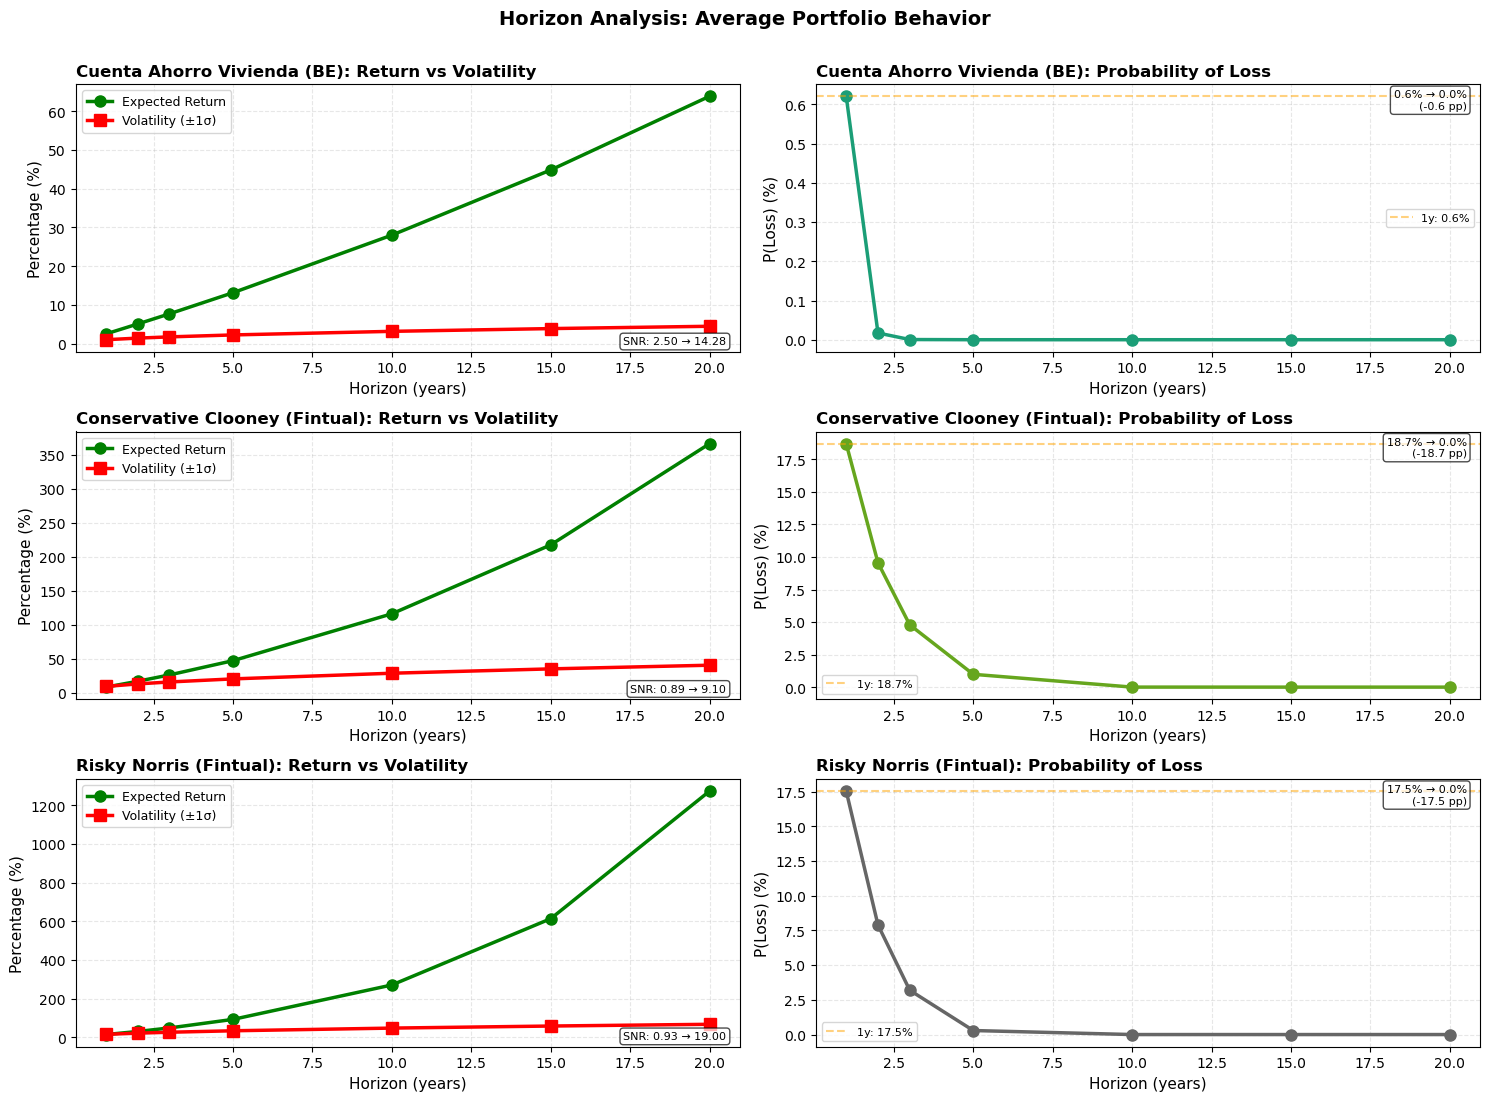

In [10]:
# --- Horizon analysis (average portfolio behavior) ---
mode = 'returns_horizon'
model.plot(mode = 'returns_horizon', show_table=False)

# Portfolio Module

## Wealth Projection Under Allocation Policy

**Recursive dynamics** (without withdrawals):
$$
W_{t+1}^m = (W_t^m + A_t x_t^m) \,(1 + R_t^m)
$$

**Recursive dynamics** (with withdrawals):
$$
W_{t+1}^m = (W_t^m + A_t x_t^m - D_t^m) \,(1 + R_t^m)
$$

We define $A_t^m = A_t \cdot x_t^m$ which is the contribution allocated to account $m$ via policy $X = \{x_t^m\}_{t,m}$, and $D_t^m$ is the withdrawal from account $m$ in month $t$.

**Closed-form representation**:
$$
W_t^m = W_0^m \, F_{0,t}^m + \sum_{s=0}^{t-1} (A_s \, x_s^m - D_s^m) \, F_{s,t}^m
$$
with accumulation factor $F_{s,t}^m = \prod_{r=s}^{t-1} (1 + R_r^m)$.

**Key insight**: $W_t^m(X)$ is **linear affine in policy** $X$ → analytical gradients enable convex optimization. Since $D$ is a parameter (not a decision variable), convexity is preserved.

**What to observe**:
- Top-left: wealth per account with Monte Carlo trajectories
- Top-right: total wealth + final distribution histogram
- Bottom-left: portfolio composition over time
- Bottom-right: allocation policy heatmap

/home/mlioi/fin-opt/src/portfolio.py:1248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.01, 1, 0.96 if title else 1])


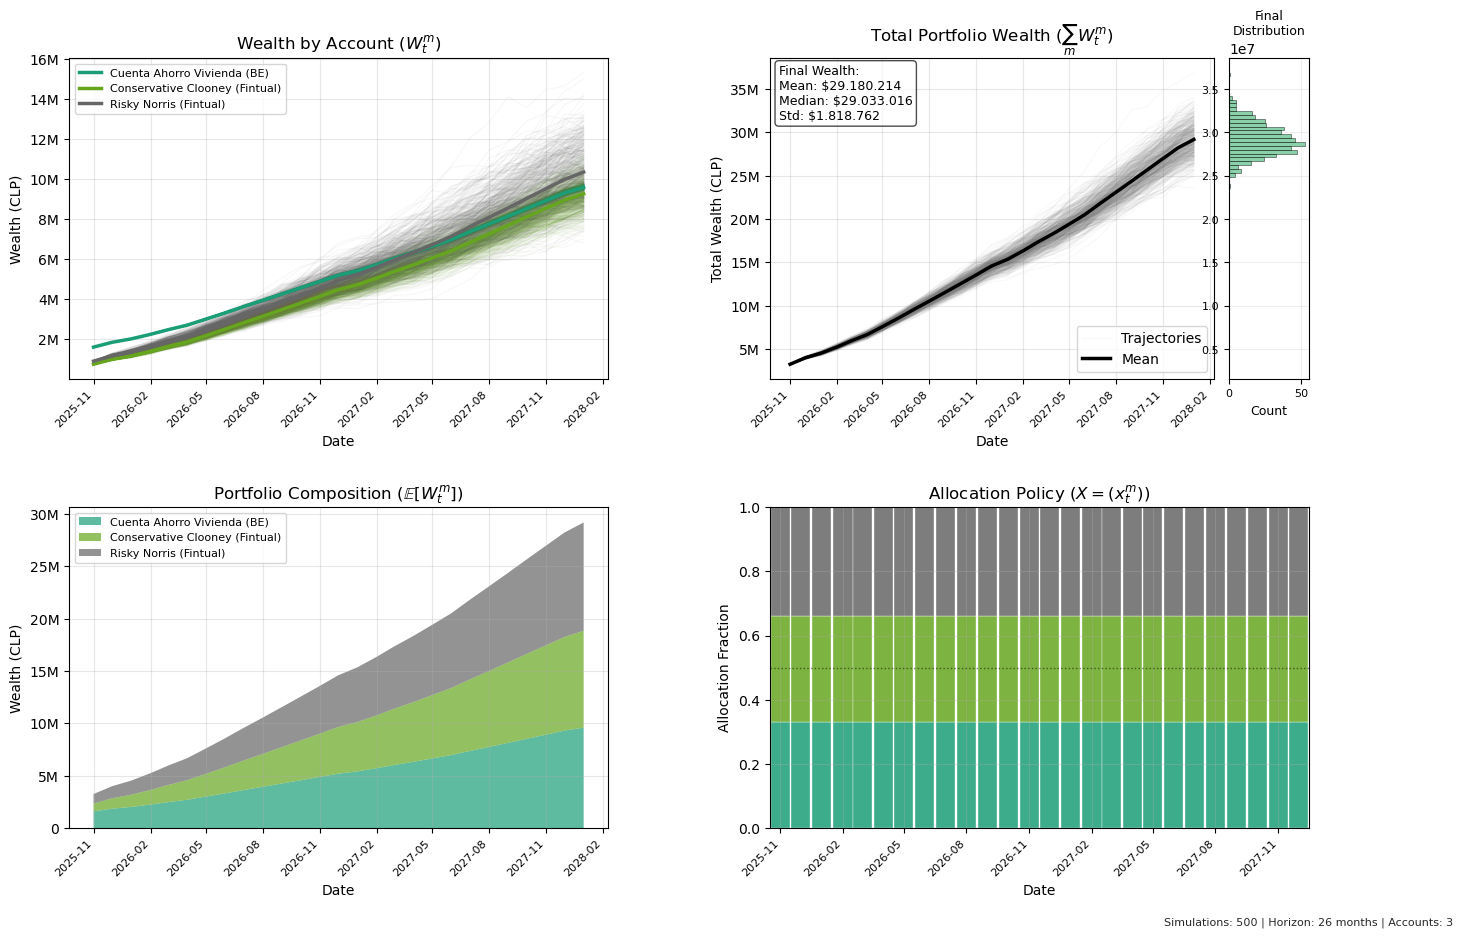

In [11]:
# Define Allocation Policy

X_static = np.tile([0.33, 0.33, 0.34], (months, 1))  # shape (months, 2)

# Project monthly Wealth
model.plot(mode = 'wealth', start=start_date, T=months, X=X_static)

# Withdrawal Module

## Scheduled Cash Outflows

The withdrawal module models planned cash outflows (retiros) from investment accounts. These represent purchases, emergency expenses, or periodic distributions that reduce portfolio wealth.

**Wealth dynamics with withdrawals**:
$$
W_{t+1}^m = (W_t^m + A_t \cdot x_t^m - D_t^m)(1 + R_t^m)
$$

where $D_t^m$ is the withdrawal from account $m$ in month $t$. Withdrawals occur at the **START** of the month (before returns are applied), meaning the withdrawn amount does not earn returns that month.

**Affine representation** (critical for convex optimization):
$$
W_t^m = W_0^m \cdot F_{0,t}^m + \sum_{s=0}^{t-1} (A_s \cdot x_s^m - D_s^m) \cdot F_{s,t}^m
$$

**Key insight**: $D$ is a **PARAMETER** (not a decision variable), so the representation remains affine in $X$, preserving convexity for CVaR optimization.

## Withdrawal Types

1. **WithdrawalEvent**: Single scheduled withdrawal at a specific date
   - Deterministic amount (same across all scenarios)
   - Calendar-aware date resolution

2. **StochasticWithdrawal**: Withdrawal with uncertainty
   - Samples from truncated Gaussian: $D \sim \mathcal{N}(\mu, \sigma^2)$ with floor/cap
   - Models variable expenses (medical costs, emergency repairs)

3. **WithdrawalModel**: Facade combining scheduled + stochastic withdrawals

## Withdrawal Schedule Configuration

In [12]:
# --- Define Withdrawal Schedule ---

# Scheduled withdrawals (deterministic)
scheduled_withdrawals = WithdrawalSchedule(events=[
    # Housing down payment from savings account
    WithdrawalEvent(
        account="Cuenta Ahorro Vivienda (BE)",
        amount=2_500_000,
        date=date(2026, 12, 1),
        description="Pie departamento"
    ),
    # Vacation from conservative fund
    WithdrawalEvent(
        account="Conservative Clooney (Fintual)",
        amount=800_000,
        date=date(2026, 6, 1),
        description="Vacaciones invierno"
    ),
])

# Stochastic withdrawals (with uncertainty)
stochastic_withdrawals = [
    StochasticWithdrawal(
        account="Conservative Clooney (Fintual)",
        base_amount=300_000,
        sigma=100_000,
        date=date(2026, 9, 1),
        floor=100_000,
        cap=600_000,
        seed=42
    ),
]

# Combined withdrawal model
withdrawal_model = WithdrawalModel(
    scheduled=scheduled_withdrawals,
    stochastic=stochastic_withdrawals
)

# Display withdrawal summary
print("=" * 70)
print("WITHDRAWAL SCHEDULE SUMMARY")
print("=" * 70)

print("\nScheduled Withdrawals (Deterministic):")
for event in scheduled_withdrawals.events:
    print(f"  - {event.date.strftime('%Y-%m')}: ${event.amount:,.0f} from {event.account}")
    if event.description:
        print(f"    Purpose: {event.description}")

print("\nStochastic Withdrawals (Variable):")
for w in stochastic_withdrawals:
    timing = f"month {w.month}" if w.month is not None else w.date.strftime('%Y-%m')
    print(f"  - {timing}: ${w.base_amount:,.0f} +/- ${w.sigma:,.0f} from {w.account}")
    print(f"    Range: [${w.floor:,.0f}, ${w.cap:,.0f}]" if w.cap else f"    Floor: ${w.floor:,.0f}")

# Expected totals by account
expected_totals = withdrawal_model.total_expected(accounts)
print("\nExpected Total Withdrawals by Account:")
for acc_name, total in expected_totals.items():
    if total > 0:
        print(f"  - {acc_name}: ${total:,.0f}")

print("\n" + "=" * 70)

WITHDRAWAL SCHEDULE SUMMARY

Scheduled Withdrawals (Deterministic):
  - 2026-12: $2,500,000 from Cuenta Ahorro Vivienda (BE)
    Purpose: Pie departamento
  - 2026-06: $800,000 from Conservative Clooney (Fintual)
    Purpose: Vacaciones invierno

Stochastic Withdrawals (Variable):
  - 2026-09: $300,000 +/- $100,000 from Conservative Clooney (Fintual)
    Range: [$100,000, $600,000]

Expected Total Withdrawals by Account:
  - Cuenta Ahorro Vivienda (BE): $2,500,000
  - Conservative Clooney (Fintual): $1,100,000



## Withdrawal Array Visualization

Convert the withdrawal schedule to a numerical array for simulation. The array has shape `(n_sims, T, M)` where stochastic withdrawals vary across scenarios.

Withdrawal array shape: (500, 26, 3)
  - n_sims: 500
  - T (months): 26
  - M (accounts): 3


/tmp/ipykernel_30897/3636882042.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right')


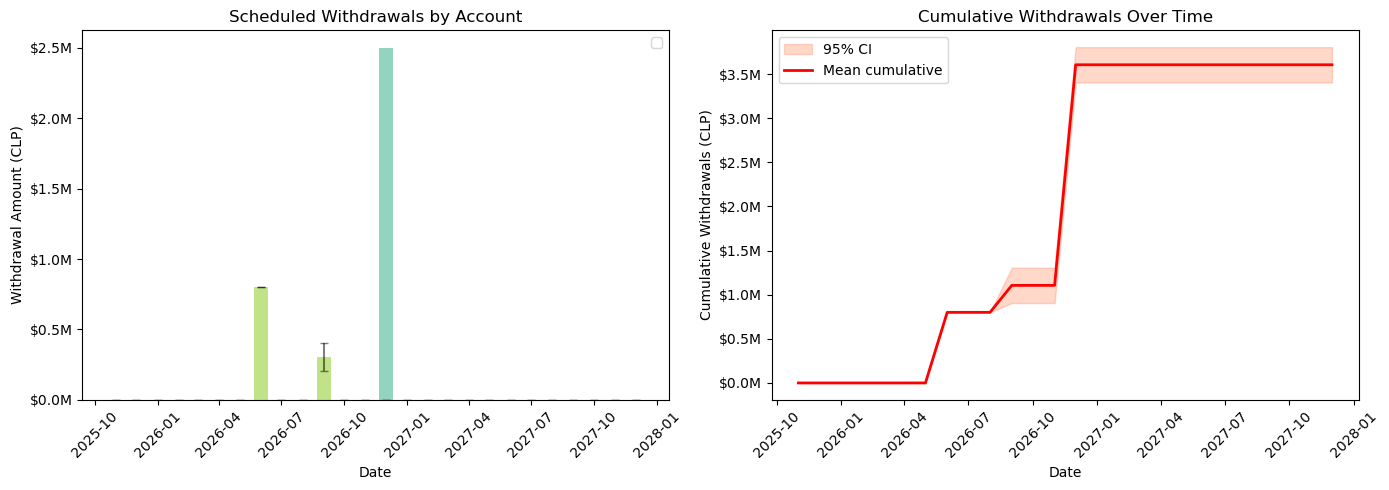


WITHDRAWAL STATISTICS
Total withdrawals per scenario:
  Mean: $3,605,493
  Std:  $99,999
  Min:  $3,400,000
  Max:  $3,888,409


In [13]:
# Generate withdrawal array for visualization
D_array = withdrawal_model.to_array(
    T=months,
    start_date=start_date,
    accounts=accounts,
    n_sims=n_sims,
    seed=42
)

print(f"Withdrawal array shape: {D_array.shape}")
print(f"  - n_sims: {D_array.shape[0]}")
print(f"  - T (months): {D_array.shape[1]}")
print(f"  - M (accounts): {D_array.shape[2]}")

# Create visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Withdrawal timeline by account (mean + std)
ax1 = axes[0]
dates = pd.date_range(start=start_date, periods=months, freq='MS')
colors = plt.cm.Set2(np.linspace(0, 1, len(accounts)))

for m, (acc, color) in enumerate(zip(accounts, colors)):
    D_account = D_array[:, :, m]
    mean_withdrawal = D_account.mean(axis=0)
    std_withdrawal = D_account.std(axis=0)
    
    # Only plot if there are withdrawals
    if mean_withdrawal.sum() > 0:
        ax1.bar(dates, mean_withdrawal, width=20, alpha=0.7, label=acc.display_name, color=color)
        # Add error bars for stochastic withdrawals
        if std_withdrawal.max() > 0:
            ax1.errorbar(dates, mean_withdrawal, yerr=std_withdrawal, 
                        fmt='none', color='black', alpha=0.5, capsize=3)

ax1.set_xlabel('Date')
ax1.set_ylabel('Withdrawal Amount (CLP)')
ax1.set_title('Scheduled Withdrawals by Account')
ax1.legend(loc='upper right')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
ax1.tick_params(axis='x', rotation=45)

# Right: Cumulative withdrawals over time
ax2 = axes[1]
cumulative_total = D_array.sum(axis=2).cumsum(axis=1)  # Sum across accounts, cumsum over time
mean_cumulative = cumulative_total.mean(axis=0)
std_cumulative = cumulative_total.std(axis=0)

ax2.fill_between(dates, 
                 mean_cumulative - 2*std_cumulative, 
                 mean_cumulative + 2*std_cumulative,
                 alpha=0.3, color='coral', label='95% CI')
ax2.plot(dates, mean_cumulative, 'r-', linewidth=2, label='Mean cumulative')

ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Withdrawals (CLP)')
ax2.set_title('Cumulative Withdrawals Over Time')
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("WITHDRAWAL STATISTICS")
print("=" * 70)
total_withdrawals = D_array.sum(axis=(1, 2))  # Sum over time and accounts per sim
print(f"Total withdrawals per scenario:")
print(f"  Mean: ${total_withdrawals.mean():,.0f}")
print(f"  Std:  ${total_withdrawals.std():,.0f}")
print(f"  Min:  ${total_withdrawals.min():,.0f}")
print(f"  Max:  ${total_withdrawals.max():,.0f}")

## Wealth Projection with Withdrawals

Compare wealth trajectories with and without scheduled withdrawals using the same allocation policy.

WEALTH COMPARISON: WITH vs WITHOUT WITHDRAWALS

Terminal Wealth (T=26):
  Without withdrawals: $29,085,844 (mean)
  With withdrawals:    $25,282,095 (mean)
  Difference:          $3,803,749 (mean impact)

Expected total withdrawals: $3,605,493
Actual wealth impact:       $3,803,749
Return foregone:            $198,255
  (withdrawals don't earn returns after extraction)


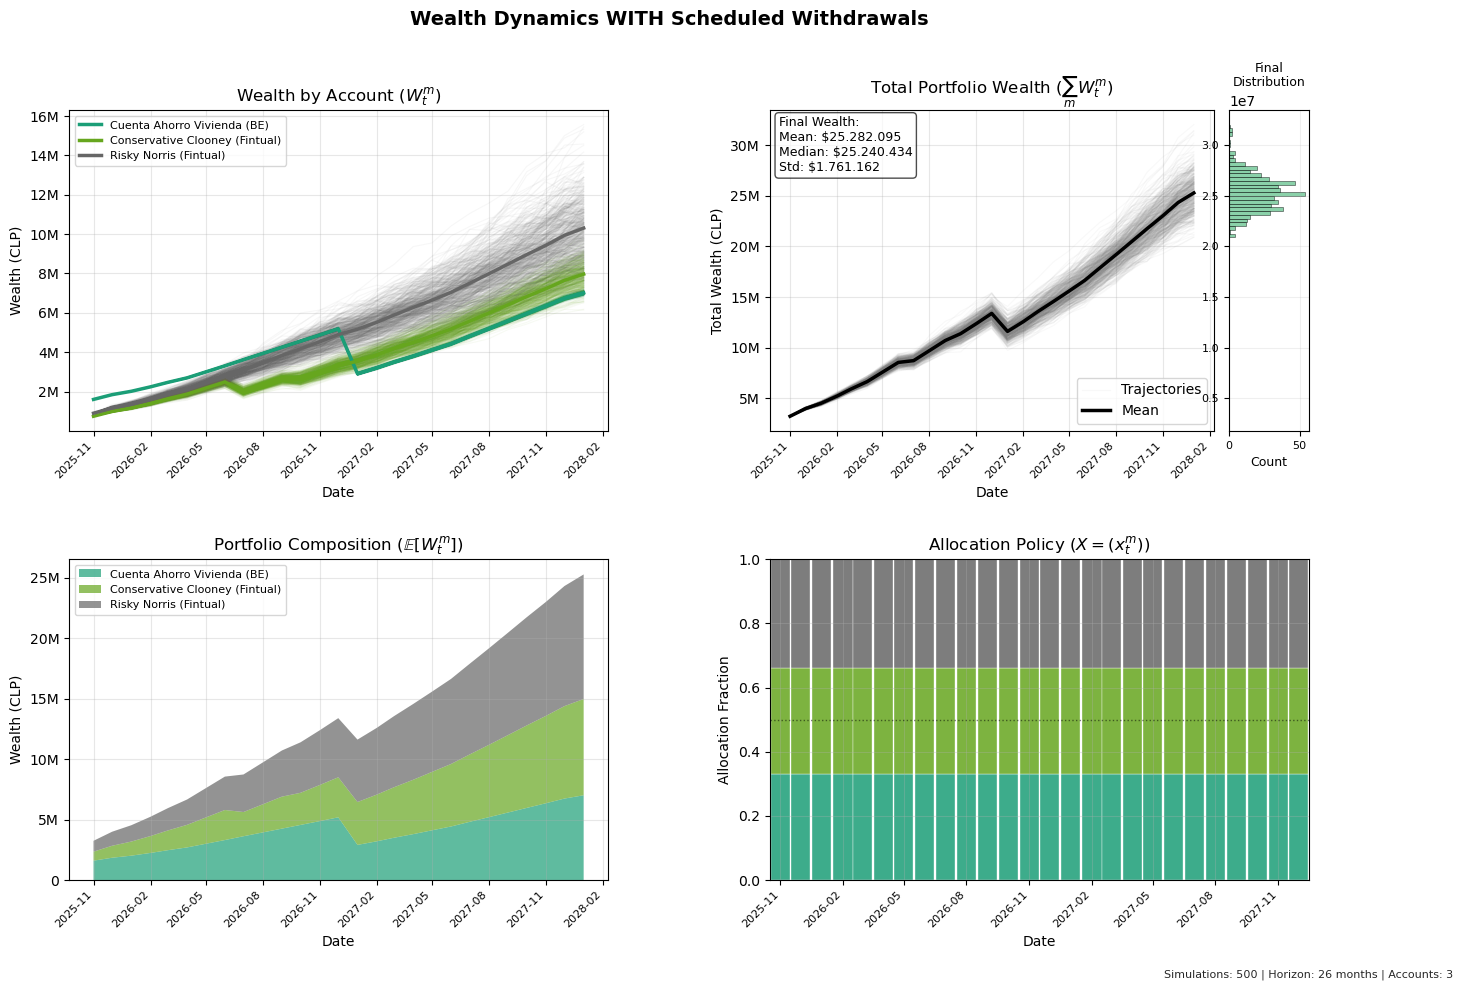

In [14]:
# Simulate wealth WITH withdrawals
result_with_withdrawals = model.simulate(
    T=months,
    X=X_static,
    n_sims=n_sims,
    start=start_date,
    seed=42,
    withdrawals=withdrawal_model
)

# Simulate wealth WITHOUT withdrawals (for comparison)
result_no_withdrawals = model.simulate(
    T=months,
    X=X_static,
    n_sims=n_sims,
    start=start_date,
    seed=42,
    withdrawals=None
)

# Compare total wealth at terminal date
print("=" * 70)
print("WEALTH COMPARISON: WITH vs WITHOUT WITHDRAWALS")
print("=" * 70)

W_with = result_with_withdrawals.total_wealth[:, -1]
W_without = result_no_withdrawals.total_wealth[:, -1]
delta = W_without - W_with

print(f"\nTerminal Wealth (T={months}):")
print(f"  Without withdrawals: ${W_without.mean():,.0f} (mean)")
print(f"  With withdrawals:    ${W_with.mean():,.0f} (mean)")
print(f"  Difference:          ${delta.mean():,.0f} (mean impact)")

print(f"\nExpected total withdrawals: ${total_withdrawals.mean():,.0f}")
print(f"Actual wealth impact:       ${delta.mean():,.0f}")
print(f"Return foregone:            ${delta.mean() - total_withdrawals.mean():,.0f}")
print("  (withdrawals don't earn returns after extraction)")

# Plot comparison
model.plot(
    mode='wealth',
    result=result_with_withdrawals,
    X=X_static,
    title="Wealth Dynamics WITH Scheduled Withdrawals",
    show_trajectories=True
)

# Goal-Driven Optimization

## Problem Formulation

### Non-Convex Chance Constraints

The **bilevel problem** seeks the minimum horizon $T^*$ satisfying all goals:

$$
\min_{T \in \mathbb{N}} \;\; T \max_{X \in \mathcal{F}_T} f(X)
$$

where the **goal-feasible set** $\mathcal{F}_T$ contains all policies $X \in \mathcal{X}_T$ satisfying probabilistic constraints:

**Intermediate goals** (at fixed time $t < T$):
$$
\mathbb{P}\big(W_t^m(X) \ge b_t^m\big) \ge 1-\varepsilon_t^m, \quad \forall g \in \mathcal{G}_{\text{int}}
$$

**Terminal goals** (at horizon $T$):
$$
\mathbb{P}\big(W_T^m(X) \ge b^m\big) \ge 1-\varepsilon^m, \quad \forall g \in \mathcal{G}_{\text{term}}
$$

with decision space (simplex):
$$
\mathcal{X}_T = \left\{ X \in \mathbb{R}^{T \times M} : x_t^m \ge 0, \; \sum_{m=1}^M x_t^m = 1, \; \forall t = 0,\ldots,T-1 \right\}
$$

**Challenge**: Chance constraints involve indicator functions $\mathbb{1}[\cdot]$, which are discontinuous and non-convex. Standard approaches (MILP, sigmoid smoothing) either scale poorly or find local optima.


## Convex Reformulation via CVaR

### CVaR Reformulation: Convex Upper Bound

We replace each chance constraint with a **CVaR constraint** (Rockafellar & Uryasev, 2000):

$$
\boxed{\mathbb{P}(W \ge b) \ge 1-\varepsilon \quad \impliedby \quad \text{CVaR}_\varepsilon(b - W) \le 0}
$$

where the **Conditional Value-at-Risk** of shortfall $L = b - W$ is:

$$
\text{CVaR}_\varepsilon(L) = \text{VaR}_\varepsilon(L) + \frac{1}{\varepsilon} \mathbb{E}\big[(L - \text{VaR}_\varepsilon(L))_+\big]
$$

**Epigraphic formulation** (convex, suitable for LP solvers):

$$
\text{CVaR}_\varepsilon(L) = \min_{\gamma \in \mathbb{R}} \left\{ \gamma + \frac{1}{\varepsilon N} \sum_{i=1}^N [L^i - \gamma]_+ \right\}
$$

Introducing auxiliary variables $z^i \ge [L^i - \gamma]_+$:

$$
\begin{aligned}
\text{CVaR}_\varepsilon(L) &= \min_{\gamma, z} \left\{ \gamma + \frac{1}{\varepsilon N} \sum_{i=1}^N z^i \right\} \\
\text{s.t.} \quad & z^i \ge L^i - \gamma, \quad \forall i \in [N] \\
& z^i \ge 0, \quad \forall i \in [N]
\end{aligned}
$$

**Key property**: If $W^i$ is **affine in $X$** (as in our wealth dynamics), then $\text{CVaR}_\varepsilon(b - W)$ is **convex in $X$**.

---

### Mathematical Relationship: Implication, Not Equivalence

**Theorem** (Rockafellar & Uryasev, 2000):

$$
\text{CVaR}_\varepsilon(L) \le 0 \quad \implies \quad \mathbb{P}(L \le 0) \ge 1 - \varepsilon
$$

**Proof sketch**: CVaR averages the worst $\varepsilon$-tail of the distribution. If this mean is non-positive, then at least $(1-\varepsilon)$ of scenarios satisfy $L \le 0$.

**The converse is NOT true**: $\mathbb{P}(L \le 0) \ge 1-\varepsilon$ does NOT imply CVaR $\le 0$ if the tail is heavy.

**Interpretation**: CVaR is a **conservative approximation** controlling both:
1. **Frequency** of violations (at most $\varepsilon \times 100\%$ scenarios fail)
2. **Severity** of violations (average loss in tail is non-positive)

The original chance constraint only controls frequency.

---

### Convex Reformulated Problem - Multiple Objectives

**Inner problem** (for fixed $T$):
$$
\begin{aligned}
\max_{X, \gamma, z} \quad & f(X) \\
\text{s.t.} \quad & \sum_{m=1}^M x_t^m = 1, \quad \forall t = 0,\ldots,T-1 \quad \text{(simplex)} \\
& x_t^m \ge 0, \quad \forall t, m \quad \text{(non-negativity)} \\
& z_g^i \ge (b_g - W_{t_g}^{i,m_g}(X)) - \gamma_g, \quad \forall g, i \quad \text{(epigraph)} \\
& z_g^i \ge 0, \quad \forall g, i \\
& \gamma_g + \frac{1}{\varepsilon_g N} \sum_{i=1}^N z_g^i \le 0, \quad \forall g \quad \text{(CVaR constraint)}
\end{aligned}
$$

where:
- $W_{t}^{i,m}(X) = W_0^m F^i_{0,t,m} + \sum_{s=0}^{t-1} A^i_s \cdot x_s^m \cdot F^i_{s,t,m}$ **(affine in** $X$**)**
- $g$ indexes goals (both intermediate and terminal)
- $t_g, m_g, b_g, \varepsilon_g$ are parameters of goal $g$
- $f(X)$ is a convex objective function (see supported objectives below)

---

**Global optimality guaranteed** via convex programming (interior-point methods).

### Comparison: Original vs. CVaR

**Observed conservativeness** (empirical):
- CVaR constraint: $\text{CVaR}_\varepsilon(L) \le 0$
- Resulting violation rate: typically $(0.5-0.8) \times \varepsilon$ (better than required)

**Example** (from our results):
- Goal: $\mathbb{P}(W_T \ge 1\text{M}) \ge 80\%$ (i.e., $\varepsilon = 20\%$)
- CVaR solution: violation rate = 9% (margin of 11%)

The 11% buffer is the "price" of convexity, buying us certified global optimality and numerical stability.

## Goal Specification

In [15]:
# --- Define Financial Goals ---

# Goal 1: Emergency Fund
goal_emergency = TerminalGoal(
    account="Conservative Clooney (Fintual)",
    threshold=5_000_000,
    confidence=0.5
)

# Goal 2: Investing Fund (Terminal)
goal_investing = TerminalGoal(
    account="Risky Norris (Fintual)",
    threshold=8_000_000,
    confidence=0.5
)

# Goal 3: Housing Fund
goal_home_intermediate = IntermediateGoal(
    account="Cuenta Ahorro Vivienda (BE)",
    threshold=3_100_000,
    confidence=0.5,
    month=12
)

# Goal 4: Emergency liquidity required
goal_emergency_intermediate = IntermediateGoal(
    account="Conservative Clooney (Fintual)",
    threshold=3_000_000,
    confidence=0.5,
    month=10
)

goals = [goal_emergency, goal_investing, goal_home_intermediate, goal_emergency_intermediate]

# Display goal summary
print("=" * 70)
print("FINANCIAL GOALS SUMMARY")
print("=" * 70)
for i, g in enumerate(goals, 1):
    if isinstance(g, IntermediateGoal):
        print(f"\n{i}.")
        print(f"   Type: Intermediate (month {g.month})")
        print(f"   Account: {g.account}")
        print(f"   Threshold: ${g.threshold:,.0f}")
        print(f"   Minimum Confidence: {g.confidence:.0%} (ε={g.epsilon:.0%})")
    else:
        print(f"\n{i}.")
        print(f"   Type: Terminal (horizon T to be optimized)")
        print(f"   Account: {g.account}")
        print(f"   Threshold: ${g.threshold:,.0f}")
        print(f"   Minimum Confidence: {g.confidence:.0%} (ε={g.epsilon:.0%})")
print("=" * 70)

FINANCIAL GOALS SUMMARY

1.
   Type: Terminal (horizon T to be optimized)
   Account: Conservative Clooney (Fintual)
   Threshold: $5,000,000
   Minimum Confidence: 50% (ε=50%)

2.
   Type: Terminal (horizon T to be optimized)
   Account: Risky Norris (Fintual)
   Threshold: $8,000,000
   Minimum Confidence: 50% (ε=50%)

3.
   Type: Intermediate (month 12)
   Account: Cuenta Ahorro Vivienda (BE)
   Threshold: $3,100,000
   Minimum Confidence: 50% (ε=50%)

4.
   Type: Intermediate (month 10)
   Account: Conservative Clooney (Fintual)
   Threshold: $3,000,000
   Minimum Confidence: 50% (ε=50%)


## Bilevel Optimization

### Withdrawal Feasibility Constraints

When scheduled withdrawals $D_t^m$ are present, the optimizer adds **probabilistic feasibility constraints** ensuring sufficient wealth exists before each withdrawal:

$$
\mathbb{P}(W_t^m \ge D_t^m) \ge 1 - \varepsilon_{\text{wd}}, \quad \forall t, m \text{ where } D_t^m > 0
$$

These are reformulated using CVaR (same technique as goal constraints):

$$
\text{CVaR}_{\varepsilon_{\text{wd}}}(D_t^m - W_t^m) \le 0
$$

**Key insight**: Since $D$ is a **PARAMETER** (not a decision variable), the affine structure $W_t^m(X)$ is preserved, and all constraints remain convex in $X$.

The modified wealth dynamics in the optimizer:
$$
W_t^m = W_0^m \cdot F_{0,t}^m + \sum_{s=0}^{t-1} (A_s \cdot x_s^m - D_s^m) \cdot F_{s,t}^m
$$

### Supported Convex Objectives

CVaROptimizer supports 7 convex objectives exploiting affine wealth structure: Consider $W_{t}^{i,m}(X) = W_0^m F^i_{0,t,m} + \sum_{s=0}^{t-1} A^i_s \cdot x_s^m \cdot F^i_{s,t,m}$ and $\mathbb{E}\left[\sum_{m=1}^M W_T^m\right] = \frac{1}{N}\sum_{i=1}^N \sum_{m=1}^M W_T^{i,m}(X)$.

**1. risky** — Growth maximization
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right]
$$

**2. balanced** — Equal contribution across time
$$
\max_{X} \quad - \sum_{t=1}^{T-1}\sum_{m=1}^M (x_t^m - x_{t-1}^m)^2
$$

**3. risky_turnover** — Growth maximization with penalty over contributions across time
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] - \sum_{t=1}^{T-1}\sum_{m=1}^M (x_t^m - x_{t-1}^m)^2
$$

**4. conservative** — Minimize variance, chose conservative portfolio
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] - \lambda \cdot \text{Var}\left(\sum_{m=1}^M W_T^m\right)
$$

In [16]:
# --- Execute Optimization ---

print("\n" + "=" * 70)
print("BILEVEL OPTIMIZATION: COMPARING WITH/WITHOUT WITHDRAWALS")
print("=" * 70)

objective_params = {'lambda' : 50}
optimizer = CVaROptimizer(n_accounts=model.M, objective='balanced', objective_params=objective_params)

# --- Optimization WITHOUT withdrawals ---
print("\n>>> Test 1: Optimizing WITHOUT withdrawals...")
opt_result_no_wd = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=120,
    n_sims=400,
    seed=42,
    verbose=True,
    withdrawals=None,  # No withdrawals
    solver='ECOS',
    max_iters=10000
)

# --- Optimization WITH withdrawals ---
print("\n>>> Test 2: Optimizing WITH withdrawals...")
opt_result = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=120,
    n_sims=400,
    seed=42,
    verbose=True,
    withdrawals=withdrawal_model,  # Include withdrawal constraints
    withdrawal_epsilon=0.05,       # 95% confidence for withdrawal feasibility
    solver='ECOS',
    max_iters=10000
)

# --- Comparison ---
print("\n" + "=" * 70)
print("OPTIMIZATION COMPARISON")
print("=" * 70)
print(f"\n  WITHOUT withdrawals:")
print(f"    T* = {opt_result_no_wd.T} months")
print(f"    Objective = {opt_result_no_wd.objective_value:.4f}")
print(f"\n  WITH withdrawals:")
print(f"    T* = {opt_result.T} months")
print(f"    Objective = {opt_result.objective_value:.4f}")
print(f"    Withdrawal constraints = {opt_result.diagnostics.get('withdrawal_constraints', 0)}")

delta_T = opt_result.T - opt_result_no_wd.T
if delta_T > 0:
    print(f"\n  Impact: +{delta_T} month(s) required to fund withdrawals while meeting goals")
elif delta_T == 0:
    print(f"\n  Impact: No change in optimal horizon (withdrawals absorbed without delay)")
else:
    print(f"\n  Impact: {delta_T} month(s) - unusual, verify constraints")

print("\n" + "=" * 70)
print("SELECTED RESULT: WITH WITHDRAWALS")
print("=" * 70)
print(opt_result.summary())


BILEVEL OPTIMIZATION: COMPARING WITH/WITHOUT WITHDRAWALS

>>> Test 1: Optimizing WITHOUT withdrawals...

=== GoalSeeker: BINARY search T ∈ [12, 120] ===
[Iter 1] Binary search: testing T=66 (range=[12, 120])...


/home/mlioi/anaconda3/envs/finance/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


    ✓ Feasible, obj=-0.00, time=0.504s

[Iter 2] Binary search: testing T=39 (range=[12, 66])...
    ✓ Feasible, obj=-0.00, time=0.207s

[Iter 3] Binary search: testing T=25 (range=[12, 39])...
    ✓ Feasible, obj=-0.00, time=0.086s

[Iter 4] Binary search: testing T=18 (range=[12, 25])...
    ✓ Feasible, obj=-0.07, time=0.078s

[Iter 5] Binary search: testing T=15 (range=[12, 18])...
    ✗ Infeasible, obj=0.00, time=0.290s

[Iter 6] Binary search: testing T=17 (range=[16, 18])...
    ✓ Feasible, obj=-0.93, time=0.324s

[Iter 7] Binary search: testing T=16 (range=[16, 17])...
    ✓ Feasible, obj=-0.46, time=1.785s

=== Optimal: T*=16 (binary search converged) ===


>>> Test 2: Optimizing WITH withdrawals...

=== GoalSeeker: BINARY search T ∈ [12, 120] ===
[Iter 1] Binary search: testing T=66 (range=[12, 120])...
    ✓ Feasible, obj=-0.00, time=0.927s

[Iter 2] Binary search: testing T=39 (range=[12, 66])...
    ✓ Feasible, obj=-0.00, time=0.299s

[Iter 3] Binary search: testing T=25 (r

In [17]:
optimizer.objective

'balanced'

## Optimal Policy Analysis

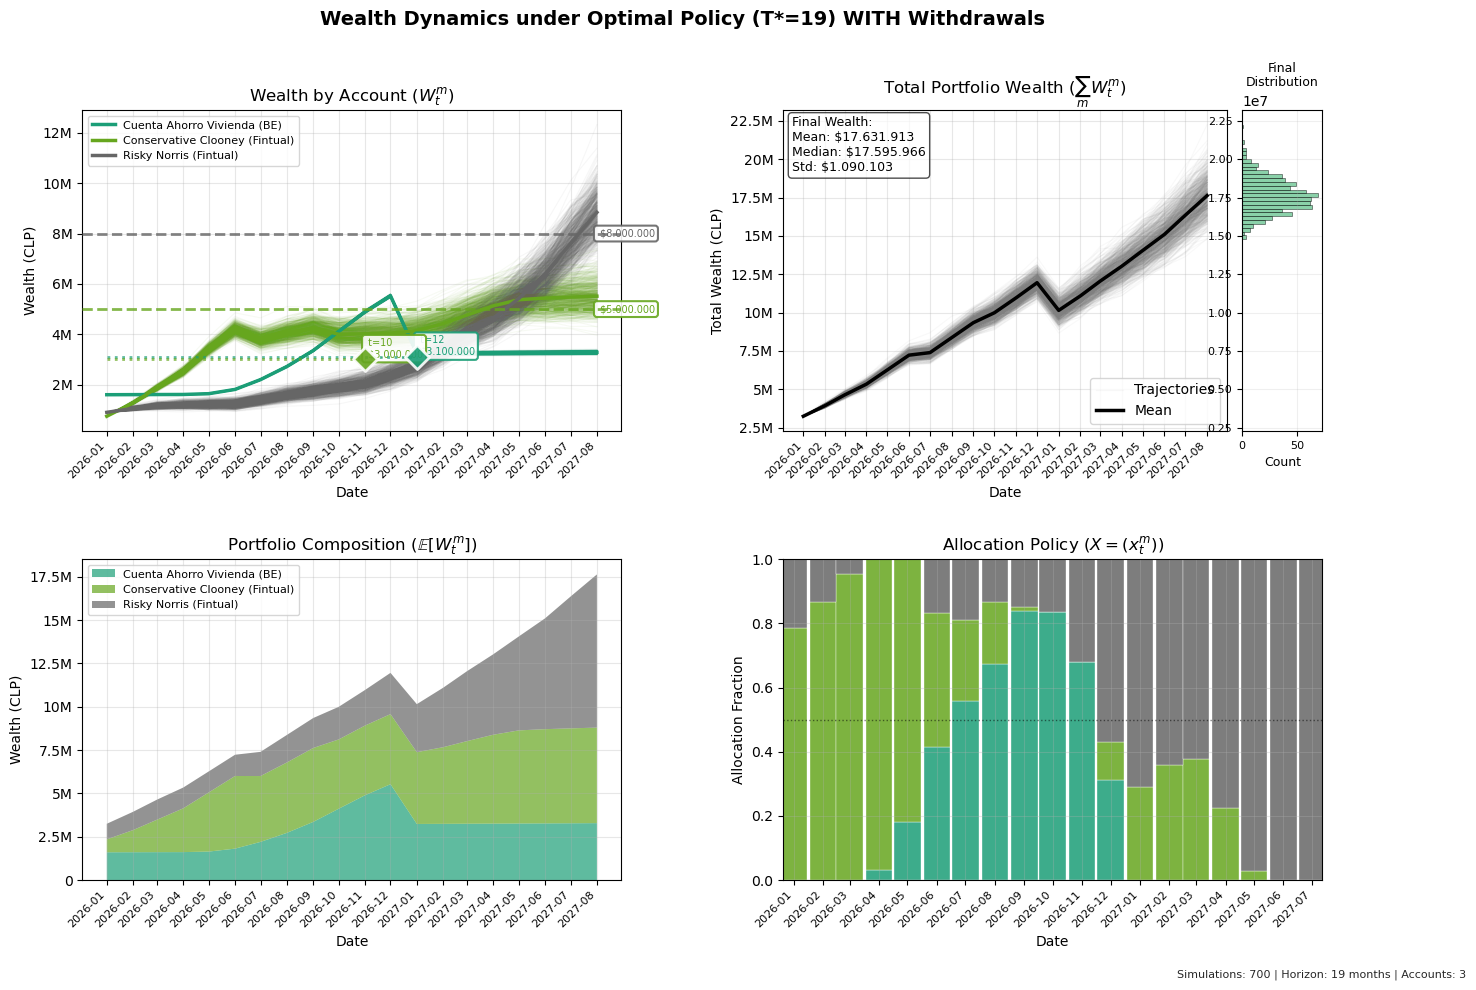

In [18]:
# --- Simulate wealth under X* WITH withdrawals ---

# Generate fresh scenarios for validation (out-of-sample)
opt_sim = model.simulate_from_optimization(
    opt_result,
    n_sims=700,
    seed=999,  # Different seed from optimization
    withdrawals=withdrawal_model  # Include withdrawals in simulation
)

# Plot wealth dynamics
model.plot(
    mode='wealth',
    result=opt_sim,
    X=opt_result.X,
    title=f"Wealth Dynamics under Optimal Policy (T*={opt_result.T}) WITH Withdrawals",
    show_trajectories=True,
    goals=goals
)

/home/mlioi/fin-opt/src/model.py:1975: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.97 if title else 0.99])


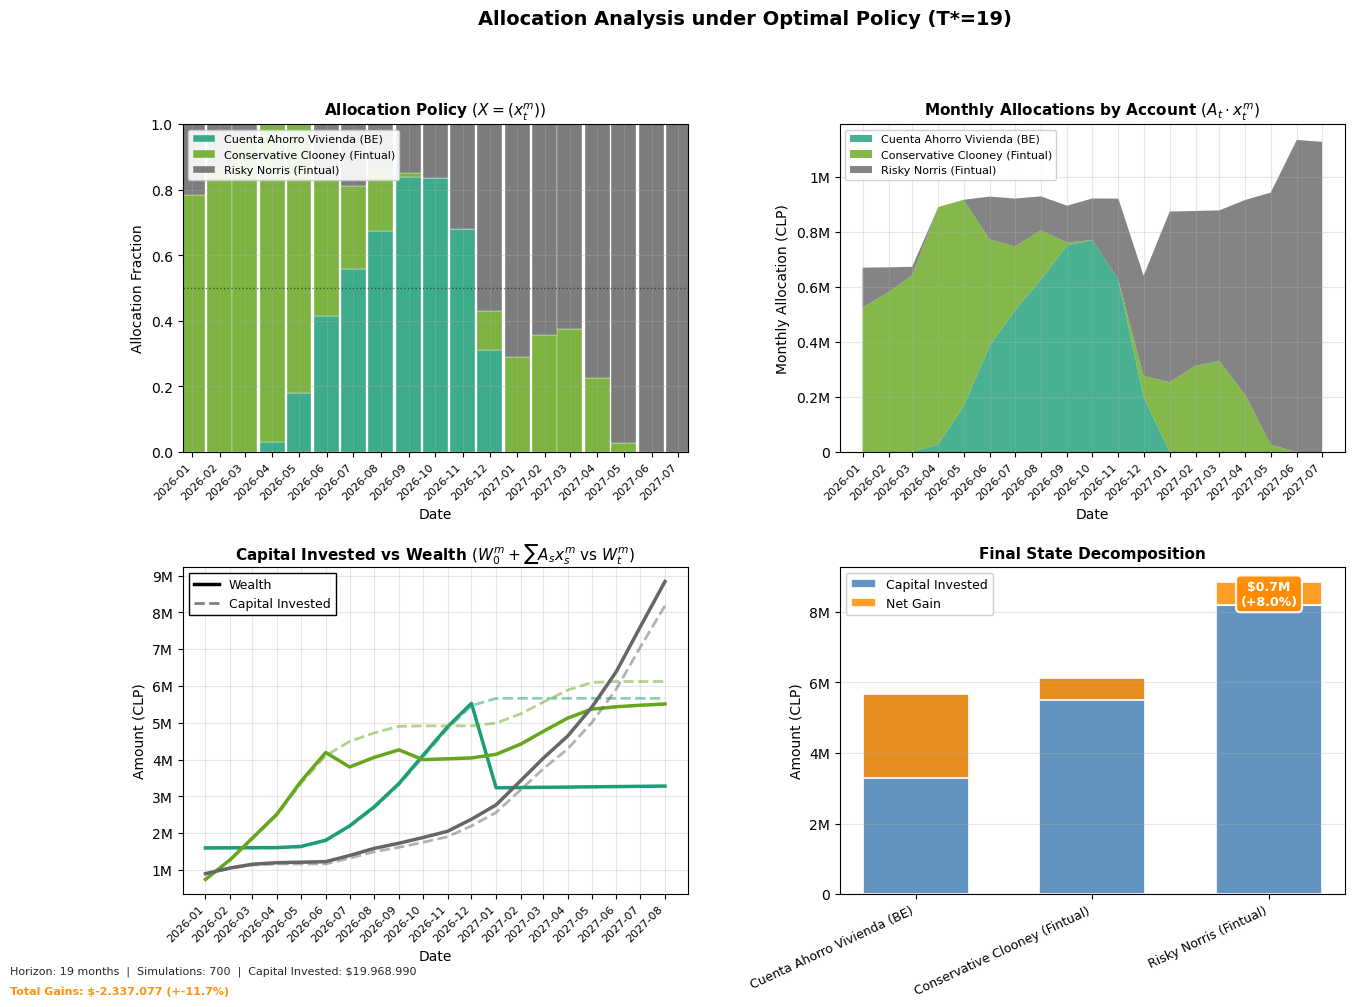

In [19]:
# Plot allocation analysis with investment gains
model.plot(
    mode='allocation',
    result=opt_sim,
    X=opt_result.X,
    title=f"Allocation Analysis under Optimal Policy (T*={opt_result.T})",
    show_trajectories=False
)

## Goal Verification

### In-Sample Verification

In [20]:
print("=" * 70)
print("GOAL VERIFICATION: IN-SAMPLE (WITH WITHDRAWALS)")
print("=" * 70)
print("Using optimization scenarios (n=300, seed=42)")
print("Expected: All goals satisfied (✓)\n")

# Simulate with optimization parameters INCLUDING withdrawals
insample_sim = model.simulate(
    T=opt_result.T,
    X=opt_result.X,
    n_sims=300,
    seed=42,  # Same seed as optimization
    start=start_date,
    withdrawals=withdrawal_model  # Include withdrawals
)

insample_status = model.verify_goals(insample_sim, goals, start=start_date)

# Display results
for goal, metrics in insample_status.items():
    print(f"  Account: {goal.account}")
    if isinstance(goal, IntermediateGoal):
        print(f"  Month: {goal.month}")
    print(f"  Threshold: ${goal.threshold:,.0f}")
    print(f"  Minimum Confidence: {goal.confidence:.0%}")
    print(f"  ---")
    status_symbol = "✓" if metrics['satisfied'] else "✗"
    print(f"  Status: {status_symbol} {'SATISFIED' if metrics['satisfied'] else 'VIOLATED'}")
    print(f"  Violation rate: {metrics['violation_rate']:.2%} (required ≤ {metrics['required_rate']:.2%})")
    print(f"  Margin: {metrics['margin']:.2%}")
    print(f"  Median shortfall: ${metrics['median_shortfall']:,.0f}")
    print(f"  N violations: {metrics['n_violations']} / {insample_sim.n_sims}")

print("\n" + "=" * 70)

GOAL VERIFICATION: IN-SAMPLE (WITH WITHDRAWALS)
Using optimization scenarios (n=300, seed=42)
Expected: All goals satisfied (✓)

  Account: Conservative Clooney (Fintual)
  Threshold: $5,000,000
  Minimum Confidence: 50%
  ---
  Status: ✗ VIOLATED
  Violation rate: 60.00% (required ≤ 50.00%)
  Margin: -10.00%
  Median shortfall: $342,708
  N violations: 180 / 300
  Account: Risky Norris (Fintual)
  Threshold: $8,000,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 31.67% (required ≤ 50.00%)
  Margin: 18.33%
  Median shortfall: $404,661
  N violations: 95 / 300
  Account: Cuenta Ahorro Vivienda (BE)
  Month: 12
  Threshold: $3,100,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 0.00% (required ≤ 50.00%)
  Margin: 50.00%
  Median shortfall: $0
  N violations: 0 / 300
  Account: Conservative Clooney (Fintual)
  Month: 10
  Threshold: $3,000,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 0.00% (required ≤ 5

### Out-of-Sample Verification

In [21]:
print("\n" + "=" * 70)
print("GOAL VERIFICATION: OUT-OF-SAMPLE (WITH WITHDRAWALS)")
print("=" * 70)
print("Using fresh scenarios (n=1000, seed=999)")
print("Expected: All goals satisfied with safety margin\n")

# Generate independent scenarios WITH withdrawals
outsample_sim = model.simulate_from_optimization(
    opt_result,
    n_sims=1000,
    seed=999,  # Independent seed
    withdrawals=withdrawal_model  # Include withdrawals
)

outsample_status = model.verify_goals(outsample_sim, goals, start=start_date)

# Display results
for goal, metrics in outsample_status.items():
    print(f"  Account: {goal.account}")
    if isinstance(goal, IntermediateGoal):
        print(f"  Month: {goal.month}")
    print(f"  Threshold: ${goal.threshold:,.0f}")
    print(f"  Minimum Confidence: {goal.confidence:.0%}")
    print(f"  ---")
    status_symbol = "✓" if metrics['satisfied'] else "✗"
    print(f"  Status: {status_symbol} {'SATISFIED' if metrics['satisfied'] else 'VIOLATED'}")
    print(f"  Violation rate: {metrics['violation_rate']:.2%} (required ≤ {metrics['required_rate']:.2%})")
    print(f"  Margin: {metrics['margin']:.2%}")
    print(f"  Median shortfall: ${metrics['median_shortfall']:,.0f}")
    print(f"  N violations: {metrics['n_violations']} / {outsample_sim.n_sims}")

print("\n" + "=" * 70)

# Summary comparison
print("\n" + "=" * 70)
print("IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON")
print("=" * 70)

comparison = pd.DataFrame({
    'In-Sample (n=300)': [
        insample_status[g]['violation_rate'] for g in goals
    ],
    'Out-of-Sample (n=1000)': [
        outsample_status[g]['violation_rate'] for g in goals
    ],
    'Required (ε)': [
        g.epsilon for g in goals
    ]
})

print(comparison.round(4))
print("=" * 70)


GOAL VERIFICATION: OUT-OF-SAMPLE (WITH WITHDRAWALS)
Using fresh scenarios (n=1000, seed=999)
Expected: All goals satisfied with safety margin

  Account: Conservative Clooney (Fintual)
  Threshold: $5,000,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 16.00% (required ≤ 50.00%)
  Margin: 34.00%
  Median shortfall: $169,010
  N violations: 160 / 1000
  Account: Risky Norris (Fintual)
  Threshold: $8,000,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 13.90% (required ≤ 50.00%)
  Margin: 36.10%
  Median shortfall: $240,003
  N violations: 139 / 1000
  Account: Cuenta Ahorro Vivienda (BE)
  Month: 12
  Threshold: $3,100,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 0.00% (required ≤ 50.00%)
  Margin: 50.00%
  Median shortfall: $0
  N violations: 0 / 1000
  Account: Conservative Clooney (Fintual)
  Month: 10
  Threshold: $3,000,000
  Minimum Confidence: 50%
  ---
  Status: ✓ SATISFIED
  Violation rate: 

In [22]:
!jupyter nbconvert \
  --to pdf \
  --TagRemovePreprocessor.enabled=True \
  --TagRemovePreprocessor.remove_input_tags="['hide_input']" \
  FinOpt-Workflow.ipynb

[NbConvertApp] Converting notebook FinOpt-Workflow.ipynb to pdf
[NbConvertApp] Support files will be in FinOpt-Workflow_files/
[NbConvertApp] Making directory ./FinOpt-Workflow_files
[NbConvertApp] Writing 104756 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2016465 bytes to FinOpt-Workflow.pdf


In [23]:
!jupyter nbconvert \
  --to html \
  --TagRemovePreprocessor.enabled=True \
  --TagRemovePreprocessor.remove_input_tags="['hide_input']" \
  FinOpt-Workflow.ipynb

[NbConvertApp] Converting notebook FinOpt-Workflow.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 3346628 bytes to FinOpt-Workflow.html
